In [13]:
using CSV
using Plots
using Random
using DataFrames

In [14]:
function Measure_Eval0(system,qubo)
    m = size(qubo)[2]
    k = m^1
    born_prob = system.*system
    fitness = zeros(k)
    probs = ones(k)
    bitstring = repeat(transpose(born_prob[2,:]),k) .> rand(k,m)
    for i in 1:k
        fitness[i] = transpose(bitstring[i,:])*qubo*bitstring[i,:]

        for j in 1:size(bitstring)[2]
            probs[i] = probs[i]*born_prob[bitstring[i,j]+1,j]
        end
    end
    return transpose(fitness)*probs/sum(probs)
end  




function Measure_Eval1(system,qubo)
    m = size(qubo)[2]
    k = m^1
    born_prob = system.*system
    fitness = zeros(k)
    probs = zeros(k)
    bitstring = repeat(transpose(born_prob[2,:]),k) .> rand(k,m)
    for i in 1:k
        fitness[i] = transpose(bitstring[i,:])*qubo*bitstring[i,:]

        sol_prob = 1
        for j in 1:size(bitstring)[2]
            sol_prob = sol_prob*born_prob[bitstring[i,j]+1,j]
        end
        probs[i] = sol_prob
    end
    return transpose(fitness)*probs/sum(probs)
end        



function Measure_Eval2(system,qubo)
    m = size(qubo)[2]
    k = m^1
    born_prob = system.*system
    fitness = zeros(eltype(system))
    probs = zeros(eltype(system))
    bitstring = repeat(transpose(born_prob[2,:]),k) .> rand(k,m)
    for i in 1:k
        fitness[i] = transpose(bitstring[i,:])*qubo*bitstring[i,:]

        sol_prob = 1
        for j in 1:size(bitstring)[2]
            sol_prob = sol_prob*born_prob[bitstring[i,j]+1,j]
        end
        probs[i] = sol_prob
    end
    return transpose(fitness)*probs/sum(probs)
end        



function Measure_Eval3(system,qubo)
    m = size(qubo)[2]
    k = m^1
    born_prob = system.*system
    #fitness = zeros(k)
    #probs = zeros(k)
    fitness = 0.0
    wft = 0.0
    probs = 0.0
    bitstring = repeat(transpose(born_prob[2,:]),k) .> rand(k,m)
    for i in 1:k
        fitness = transpose(bitstring[i,:])*qubo*bitstring[i,:]

        sol_prob = 1
        for j in 1:size(bitstring)[2]
            sol_prob = sol_prob*born_prob[bitstring[i,j]+1,j]
        end
        wft += fitness*sol_prob 
        probs += sol_prob
    end
    #return transpose(fitness)*probs/sum(probs)
    return wft/probs
end


                    
                    
                    
function Rotate(T,system)
    noq = size(system)[2]
    new_system = zeros(2,noq)
    for i in 1:noq
        r = rand()
        if r > 0.5
            angle =  T/100
        elseif r < 0.5
            angle = -T/100
        end
        U = [cos(angle) -sin(angle);sin(angle) cos(angle)]
        new_system[:,i] = U*system[:,i]
    end
    return new_system
end
        


function NOT(system)
    noq = size(system)[2]
    new_system = zeros(2,noq)
    for i in 1:noq
        if rand() > 0.5
            #angle =  pi
            #U = [cos(angle) -sin(angle);sin(angle) cos(angle)]
            U = [0 1;1 0]
            new_system[:,i] = U*system[:,i]
        else
            new_system[:,i] = system[:,i]
        end
    end
    return new_system
end




function Final_measure(system)
    born_prob = system.*system
    solution_state = Int.(round.(born_prob[2,:]))
    sol_prob = 1
    for j in 1:size(solution_state)[1]
        sol_prob = sol_prob*born_prob[solution_state[j]+1,j]
    end
    #return solution_state,round(sol_prob*100,digits=3)
    return solution_state, sol_prob
end



function Replacement(current_systems,rotated_systems,fit_current,fit_rotated,T,rep_count)
    delta_fit = fit_rotated - fit_current
    println("fit rot",fit_rotated)
    println("fit_curr",fit_current)
    println(delta_fit)
    probability = 1 ./ (1 .+ exp.(delta_fit))
    println(probability)
    randoms = transpose(rand(length(probability)))
    println(randoms)
    for i in 1:length(probability)
        if probability[i] > 0.5 && probability[i] > randoms[i]
        #if probability[i] > 0.5
            current_systems[i] = rotated_systems[i]
            fit_current[i] = fit_rotated[i]
            println("System $i has been replaced")
            rep_count += 1
        end
    end
    return current_systems,fit_current,delta_fit, randoms, probability, rep_count
    #return current_systems, replacement_count, delta_fit, randoms, probability
end   



function Mutation(replaced_systems,mutated_systems,fit_replaced,fit_mutated,T,mut_count)
    delta_fit = fit_mutated - fit_replaced
    probability = 1 ./ (1 .+ exp.(delta_fit))
    randoms = transpose(rand(length(probability)))
    for i in 1:length(probability)
        #if probability[i] > 0.9 && probability[i] > randoms[i]
        if probability[i] > 0.5
            replaced_systems[i] = mutated_systems[i]
            fit_replaced[i] = fit_mutated[i]
            println("System $i has been mutated")
            mut_count += 1
        end
    end
    return replaced_systems, fit_replaced, delta_fit, randoms, probability, mut_count
    #return current_systems, replacement_count, delta_fit, randoms, probability
end 





function Migration(systems,fits,T,mig_count)
    min_fit_index = argmin(fits)[2]
    best_system = systems[min_fit_index]
    diff_fit = transpose(repeat([minimum(fits)],length(fits))) - fits
    probability = 1 ./ (1 .+ exp.(diff_fit))
    randoms = transpose(rand(length(probability)))
    for i in 1:length(probability)
        if probability[i] > 0.5 && probability[i] > randoms[i]
        #if probability[i] > 0.5
            systems[i] = best_system
            fits[i] = minimum(fits)
            println("System $min_fit_index is migrated to system $i ")
            mig_count += 1
        end
    end
    return systems, fits,diff_fit, randoms, probability, mig_count
    #return systems,migration_count, diff_fit, randoms, probability
end    



function Best(results,qubo)
    X = results[argmax(results)][1]
    prob = results[argmax(results)][2]
    E = transpose(X)*qubo*X
    return join(X),E,prob
end

Best (generic function with 1 method)

In [15]:
qubo = CSV.read("/home/aniruddha/My_Code/Workstation/Projects/Github Projects/QGA_SQA/qubos/iris_qubo.csv")
qubo = convert(Array,qubo[:,2:size(qubo)[2]])

4×4 Array{Float64,2}:
 -0.876938   0.524185   0.75179    0.565388
  0.524185  -0.51087    0.555879   0.423419
  0.75179    0.555879  -1.44632    0.677249
  0.565388   0.423419   0.677249  -1.4359

314455229]
fit_curr[-1.527715531445523 -1.527715531445523 -1.527715531445523 -1.527715531445523]
[0.02149216008141841 2.220446049250313e-16 0.000942680666201845 2.220446049250313e-16]
[0.494627166793154 0.5 0.49976432985090175 0.5]
[0.9145116566450497 0.26553328277022636 0.01321659908396322 0.4859069192522596]
system probabilities:[92.067, 92.067, 92.067, 92.067]
fit Migrated:[-1.5277 -1.5277 -1.5277 -1.5277]


############################################################## Iteration no 428
fit rot[-1.5277155314455229 -1.5277155314455229 -1.5267743427225675 -1.5277155314455229]
fit_curr[-1.527715531445523 -1.527715531445523 -1.527715531445523 -1.527715531445523]
[2.220446049250313e-16 2.220446049250313e-16 0.000941188722955566 2.220446049250313e-16]
[0.5 0.5 0.49976470283663077 0.5]
[0.23423643431548768 0.11409980668838693 0.7853266231607552 0.9076301970304299]
system probabilities:[92.067, 92.067, 92.067, 92.067]
fit Migrated:[-1.5277 -1.5277 -1.5277 -1.5277]


########################

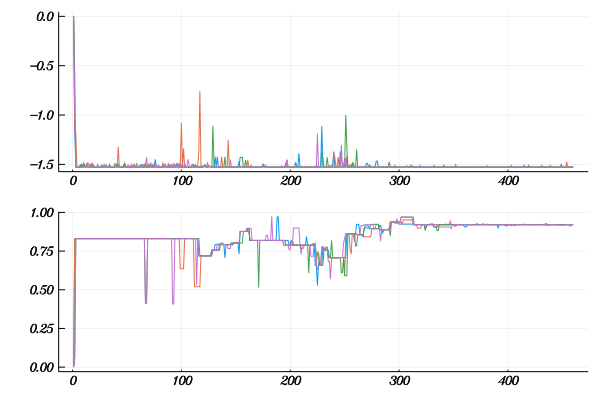

In [16]:
#Random.seed!(12)  ## using random seed

n = size(qubo)[2]
q = ones(2,n)/sqrt(2)
current_systems = repeat([q],n)


iteration,T = 0,100
iteration_count = [iteration]
temps =[]
Fits = zeros(1,n)


rep_count,mut_count,mig_count = 0,0,0
beta_squared = []
detail = zeros(1,n)
fitness_detail = zeros(1,n)
replacement_records, migration_records,mutation_records = [],[],[]
sys_prob_log = zeros(n)
all_sys_prob_log = zeros(1,n)




Start_time = time()
while any(sys_prob_log .< 0.995)==true && T > 1
    println("\n\n############################################################## Iteration no ",iteration)
    #println("Current temperature is-----------------------------------------",T)
    fit_current = transpose([Measure_Eval0(system,qubo) for system in current_systems])
    #println("fit current:",fit_current)

    
    rotated_systems = [Rotate(T,system) for system in current_systems]
    fit_rotated = transpose([Measure_Eval0(system,qubo) for system in rotated_systems])
    replaced_systems,fit_replaced,del_fit_rep,ran_rep,prob_rep,rep_count = Replacement(current_systems,rotated_systems,fit_current,fit_rotated,T,rep_count)
    #fit_replaced = transpose([Measure_Eval1(system,qubo) for system in replaced_systems])

        
    mutated_systems = [NOT(system) for system in replaced_systems]
    fit_mutated = transpose([Measure_Eval0(system,qubo) for system in mutated_systems])
    adapted_systems,fit_adapted,del_fit_adp,ran_adp,prob_adp,mut_count = Mutation(replaced_systems,mutated_systems,fit_replaced,fit_mutated,T,mut_count)
    #fit_adapted = transpose([Measure_Eval1(system,qubo) for system in adapted_systems])

        

        
        
    migrated_systems,fit_migrated,diff_fit_mig,ran_mig,prob_mig,mig_count = Migration(adapted_systems,fit_adapted,T,mig_count)        
    
    
    #fit_migrated = transpose([Measure_Eval0(system,qubo) for system in migrated_systems])
    sys_prob_log = [Final_measure(system)[2] for system in migrated_systems]


    all_sys_prob_log = [all_sys_prob_log;transpose(sys_prob_log)]
    println("system probabilities:",round.(sys_prob_log*100,digits=3))


    println("fit Migrated:",round.(fit_migrated,digits=4))
    Fits = [Fits;fit_migrated]

    ###########################################
    #fitness_detail = [fitness_detail;transpose(repeat([iteration],n));fit_current;fit_rotated;fit_replaced;fit_migrated]
    #detail = [detail;transpose(repeat([iteration],n));del_fit_rep;ran_rep;prob_rep;diff_fit_mig;ran_mig;prob_mig]
    ###########################################


    current_systems = migrated_systems
    append!(temps,T)
    T = T*0.99
    iteration += 1
end

End_time = time()


results = [Final_measure(system) for system in current_systems]
best_system,best_energy,best_prob = Best(results,qubo)



println("\n\n\n\n\n\nFinal answers are")
println("Required time is ",End_time-Start_time,"  iteration:",iteration)
println("Replacement count $rep_count , Mutation count $mut_count , Migration count $mig_count \n\n")
for i in 1:length(results)
    println(results[i][1],"----------------------------------",round(results[i][2]*100,digits=3),"%")
end





###############################  Plots   ###############################
#CSV.write("fitness_detail.csv",fitness_detail)
p1 = plot(1:size(Fits)[1],Fits[:,1],legend=false)
p1 = plot!(1:size(Fits)[1],Fits[:,2])
p1 = plot!(1:size(Fits)[1],Fits[:,3])
p1 = plot!(1:size(Fits)[1],Fits[:,4])
#ylims!(-2,1)
#xlims!(-50,500)



p2 = plot(1:size(all_sys_prob_log)[1],all_sys_prob_log[:,1],legend=false)
p2 = plot!(1:size(all_sys_prob_log)[1],all_sys_prob_log[:,2])
p2 = plot!(1:size(all_sys_prob_log)[1],all_sys_prob_log[:,3])
p2 = plot!(1:size(all_sys_prob_log)[1],all_sys_prob_log[:,4])



plot(p1,p2, layout=(2,1),legend=false)